In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('/Users/jatindhurve/Desktop/HMM_regime_portfolio_project/Data/leading_indicators.xlsx')

In [3]:
df.head(1)

,Date,VIX,PMI,yield_curve
0,1990-01-31,25.36,47.2,16.35


In [4]:
df.tail(1)

,Date,VIX,PMI,yield_curve
422,2025-03-31,22.28,49.0,31.799


In [5]:
df.isna().sum().sum()

0

In [6]:
df.columns

Index(['Date', 'VIX', 'PMI', 'yield_curve'], dtype='object')

In [7]:
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [8]:
features = ["VIX", "PMI", "yield_curve"]
mask     = df[features].notna().all(axis=1)

X      = df.loc[mask, features].values
dates  = df.loc[mask, "Date"].values       
scaler = StandardScaler()
X_std  = scaler.fit_transform(X)


In [9]:
n_states = 4
hmm = GaussianHMM(
    n_components   = n_states,
    covariance_type= "full",
    n_iter         = 1000,
    random_state   = 42,
)
hmm.fit(X_std)
states = hmm.predict(X_std)      

In [10]:
centroids = pd.DataFrame(hmm.means_, columns=features)

In [11]:
mapping = {}

# 1. Expansion → highest PMI & lowest VIX (optional tie-breaker)
expansion_idx = centroids["PMI"].idxmax()
mapping[expansion_idx] = "Expansion"

# 2. Downturn → lowest PMI & highest VIX (optional tie-breaker)
downturn_idx = centroids["PMI"].idxmin()
mapping[downturn_idx] = "Downturn"

# 3. Get remaining states
remaining = [s for s in range(n_states) if s not in mapping]

# 4. Use yield curve to split remaining into Recovery and Slowdown
remaining_df = centroids.loc[remaining]

# Recovery → higher yield curve & lower VIX (steep curve, calmer market)
# Slowdown → flatter curve or higher VIX (risk or uncertainty)
recovery_idx = remaining_df.sort_values(by=["yield_curve", "VIX"], ascending=[False, True]).index[0]
slowdown_idx = [s for s in remaining if s != recovery_idx][0]

mapping[recovery_idx] = "Recovery"
mapping[slowdown_idx] = "Slowdown"

# Map each state number to its regime label
state_labels = [mapping[s] for s in states]

In [12]:
print(centroids.round(2))

    VIX   PMI  yield_curve
0  0.89 -0.64         0.92
1 -0.13  0.48        -0.90
2 -0.63  0.17         0.51
3  0.42 -0.54        -0.91


In [13]:
reg_df = pd.DataFrame({"Date": dates, "regimes": state_labels})
df = df.merge(reg_df, on="Date", how="left")

### **Probabalities**

In [14]:
# Get smoothed probabilities (posterior probabilities for each time point)
smoothed_probs = hmm.predict_proba(X_std)

# Get steady-state probabilities (long-run equilibrium probabilities)
steady_state_probs = hmm.get_stationary_distribution()

# Create dictionary mapping regime names to steady-state probabilities
steady_state_dict = {mapping[i]: steady_state_probs[i] for i in range(n_states)}

print("Steady-State Probabilities:")
for regime, prob in steady_state_dict.items():
   print(f"{regime}: {prob:.3f}")

Steady-State Probabilities:
Downturn: 0.235
Expansion: 0.319
Recovery: 0.338
Slowdown: 0.108


In [15]:
df.head()

,Date,VIX,PMI,yield_curve,regimes
0,1990-01-31,25.36,47.2,16.35,Slowdown
1,1990-02-28,21.99,49.1,9.35,Slowdown
2,1990-03-30,19.73,49.9,0.55,Slowdown
3,1990-04-30,19.52,50.0,7.75,Slowdown
4,1990-05-31,17.37,49.5,11.65,Slowdown


In [15]:
df.to_excel("hmm_regime_identification.xlsx", index=False)

In [22]:
df = (
    df.set_index("Date")         
      .asfreq("M")                
)
df["regimes"] = df["regimes"].ffill().bfill()

# (optional) quick inspection
print(df["regimes"])

Date
1990-01-31    Slowdown
1990-02-28    Slowdown
1990-03-31    Slowdown
1990-04-30    Slowdown
1990-05-31    Slowdown
                ...   
2024-11-30    Slowdown
2024-12-31    Slowdown
2025-01-31    Slowdown
2025-02-28    Slowdown
2025-03-31    Slowdown
Freq: ME, Name: regimes, Length: 423, dtype: object


/var/folders/ky/n1n3tvzn3zb6_44x8nfzwn700000gn/T/ipykernel_18110/2698831533.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .asfreq("M")


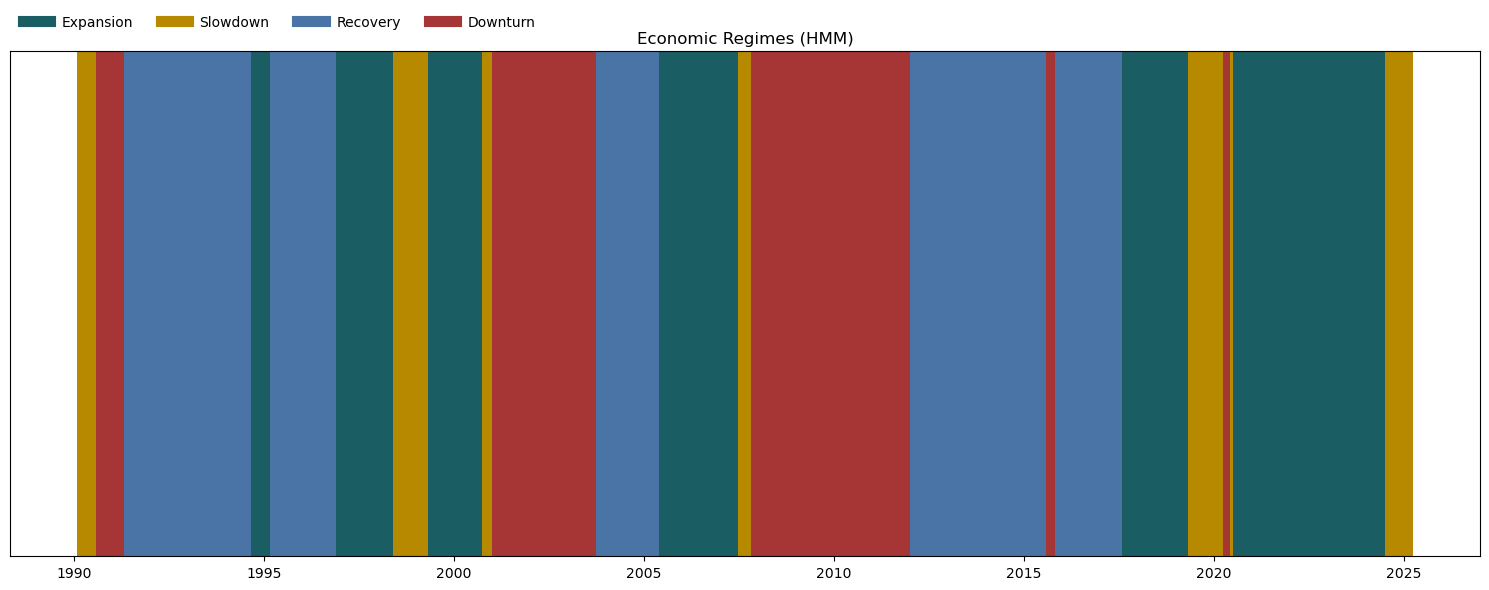

In [23]:
palette = {
    "Expansion": "#1A5E63",
    "Slowdown" : "#B68900",
    "Recovery" : "#4B74A6",
    "Downturn" : "#A63636",
}

fig, ax = plt.subplots(figsize=(15, 6))

segments = (df["regimes"] != df["regimes"].shift()).cumsum()

# Collect spans
spans = []
for _, seg in df.groupby(segments):
    regime = seg["regimes"].iloc[0]
    start = seg.index[0]
    end = seg.index[-1] + pd.offsets.MonthEnd(0)
    spans.append((start, end, regime))

# Fix: Force perfect continuity between spans
for i, (start, end, regime) in enumerate(spans):
    if i > 0:
        # Force current start = previous end
        start = spans[i - 1][1]
    ax.axvspan(start, end, color=palette[regime], lw=0)

# Clean axes
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_title("Economic Regimes (HMM)")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Legend
handles = [plt.Line2D([0], [0], lw=8, color=c) for c in palette.values()]
ax.legend(handles, palette.keys(), ncol=4, frameon=False,
          bbox_to_anchor=(0, 1.02, 1, .2), loc="lower left")

plt.tight_layout()
plt.show()

In [25]:
# -----------------------------------------------------------
# 0.  pull ground-truth data from FRED
# -----------------------------------------------------------
from pandas_datareader.data import DataReader

# Official recession dummy (monthly, 1 = recession)
usrec = DataReader("USREC", "fred", df.index.min(), df.index.max())
usrec = usrec.reindex(df.index, method="pad")          # align exactly

# S&P-500 total-return index  (use SP500 if you only need price)
spx = DataReader("SP500", "fred", df.index.min(), df.index.max())
spx = spx.reindex(df.index, method="pad")

# monthly % return
spx_ret = spx.pct_change().mul(100)

/var/folders/ky/n1n3tvzn3zb6_44x8nfzwn700000gn/T/ipykernel_18110/3515453251.py:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  spx_ret = spx.pct_change().mul(100)


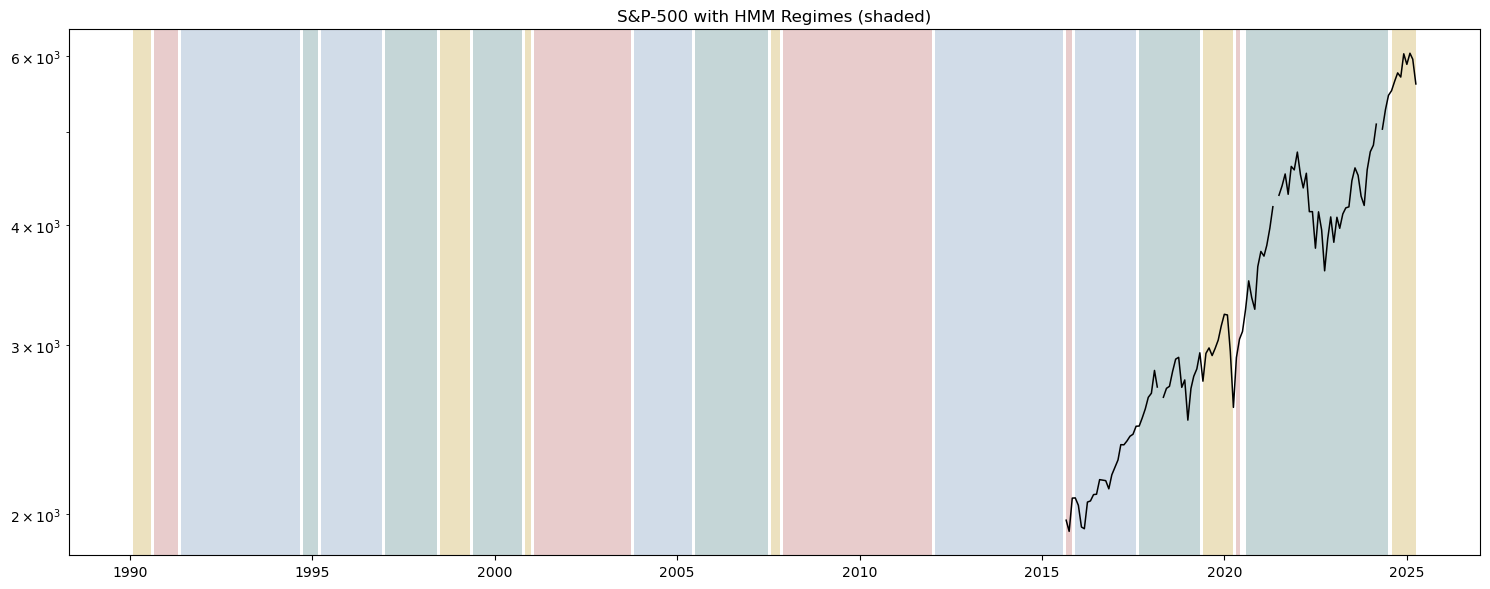

In [26]:
# -----------------------------------------------------------
# 1.  quick visual overlay  (regimes bands + S&P price line)
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

palette = {
    "Expansion": "#1A5E63",
    "Slowdown" : "#B68900",
    "Recovery" : "#4B74A6",
    "Downturn" : "#A63636",
}

fig, ax = plt.subplots(figsize=(15, 6))

# coloured background bands
segments = (df["regimes"] != df["regimes"].shift()).cumsum()
for _, seg in df.groupby(segments):
    reg   = seg["regimes"].iloc[0]
    start = seg.index[0]
    end   = seg.index[-1] + pd.offsets.MonthEnd(0)
    ax.axvspan(start, end, color=palette[reg], alpha=.25, lw=0)

# S&P-500 price
ax.plot(spx.index, spx, lw=1.1, color="k")
ax.set_yscale("log")
ax.set_title("S&P-500 with HMM Regimes (shaded)")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.show()

In [27]:
# -----------------------------------------------------------
# 2.  confusion matrix vs. recessions
# -----------------------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix

is_recession = (
    usrec["USREC"]          # 1 = recession, NaN elsewhere
      .fillna(0)            # treat gaps as “not recession”
      .astype(int)          # now it’s safe to cast
)

is_downturn  = df["regimes"].isin(["Downturn", "Slowdown"]).astype(int)

print("\nHMM recession capture (Downturn+Slowdown vs USREC):")
print(confusion_matrix(is_recession, is_downturn))
print(classification_report(is_recession, is_downturn,
                            target_names=["Expansion months","Recession months"]))

# -----------------------------------------------------------
# 3.  average S&P return by regime
# -----------------------------------------------------------
df["spx_ret"] = spx_ret
print("\nMean monthly S&P-500 return by regime (%):")
print(df.groupby("regimes")["spx_ret"].mean().round(2))


HMM recession capture (Downturn+Slowdown vs USREC):
[[280 107]
 [  0  36]]
                  precision    recall  f1-score   support

Expansion months       1.00      0.72      0.84       387
Recession months       0.25      1.00      0.40        36

        accuracy                           0.75       423
       macro avg       0.63      0.86      0.62       423
    weighted avg       0.94      0.75      0.80       423


Mean monthly S&P-500 return by regime (%):
regimes
Downturn     5.72
Expansion    1.19
Recovery     0.85
Slowdown    -0.30
Name: spx_ret, dtype: float64


In [28]:
tmp = pd.DataFrame({
    "true" : is_recession,
    "pred" : df["regimes"].isin(["Downturn", "Slowdown"]).astype(int)
}).dropna()                   # removes rows where 'true' is NaN

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(tmp["true"], tmp["pred"]))
print(classification_report(tmp["true"], tmp["pred"],
                            target_names=["Expansion months","Recession months"]))

[[280 107]
 [  0  36]]
                  precision    recall  f1-score   support

Expansion months       1.00      0.72      0.84       387
Recession months       0.25      1.00      0.40        36

        accuracy                           0.75       423
       macro avg       0.63      0.86      0.62       423
    weighted avg       0.94      0.75      0.80       423



[[280 107]
 [  0  36]]
              precision    recall  f1-score   support

   Expansion       1.00      0.72      0.84       387
   Recession       0.25      1.00      0.40        36

    accuracy                           0.75       423
   macro avg       0.63      0.86      0.62       423
weighted avg       0.94      0.75      0.80       423



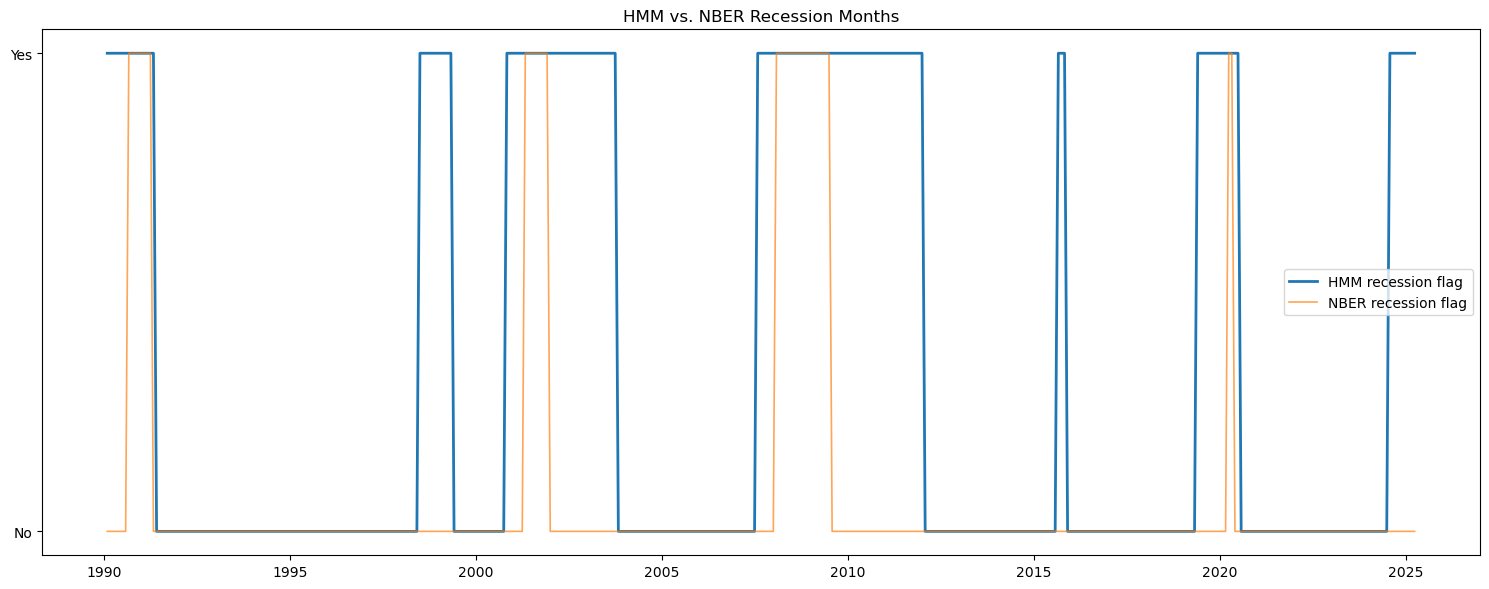

In [29]:
# ——— 1  load NBER recession dummy ———
from pandas_datareader.data import DataReader
usrec = DataReader("USREC", "fred", df.index.min(), df.index.max()).reindex(df.index, method="pad")

# ——— 2  numeric evaluation ———
from sklearn.metrics import classification_report, confusion_matrix

true  = usrec["USREC"].fillna(0).astype(int)                         # 1 = recession
pred  = df["regimes"].isin(["Downturn", "Slowdown"]).astype(int)     # your “recession” proxy

print(confusion_matrix(true, pred))
print(classification_report(true, pred, target_names=["Expansion","Recession"]))

# ——— 3  visual overlay ———
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(pred.index, pred, label="HMM recession flag", lw=2)
ax.plot(true.index, true, label="NBER recession flag", lw=1.2, alpha=.7)
ax.set_yticks([0,1]); ax.set_yticklabels(["No","Yes"])
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.legend()
plt.title("HMM vs. NBER Recession Months"); plt.tight_layout(); plt.show()

In [30]:
regime_summary = pd.DataFrame({
    'Observations': df['regimes'].value_counts(),
    'Percentage': df['regimes'].value_counts(normalize=True) * 100,
    'Years': df['regimes'].value_counts() / 12
}).round(2)
print("Table 6.1: Regime Distribution and Sample Characteristics")
print(regime_summary)

Table 6.1: Regime Distribution and Sample Characteristics
           Observations  Percentage  Years
regimes                                   
Recovery            145       34.28  12.08
Expansion           135       31.91  11.25
Downturn             97       22.93   8.08
Slowdown             46       10.87   3.83
